# Munge Data

This notebook will perform data preprocessing and exploratory data exploration. 

In [1]:
! pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

from PIL import Image 


Pokemon CSV contains the names and types of our pokemon.  The types are in two separate columns.  

In [3]:
df = pd.read_csv('data/pokemon.csv')
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [4]:
LABELS = df['Type1'].unique()
print(LABELS)

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


In [5]:
def merge_type_strings(row): 
    t1 = row['Type1']
    t2 = row['Type2']
    
    if t2 is np.nan: 
        return t1
    
    return t1 + ' ' + t2
    


df['Type'] = df.apply(lambda row: merge_type_strings(row), axis=1)
df.head()

,Name,Type1,Type2,Type
0,bulbasaur,Grass,Poison,Grass Poison
1,ivysaur,Grass,Poison,Grass Poison
2,venusaur,Grass,Poison,Grass Poison
3,charmander,Fire,NaN,Fire
4,charmeleon,Fire,NaN,Fire


## Preliminary data exploration 
### Analyze label frequencies 


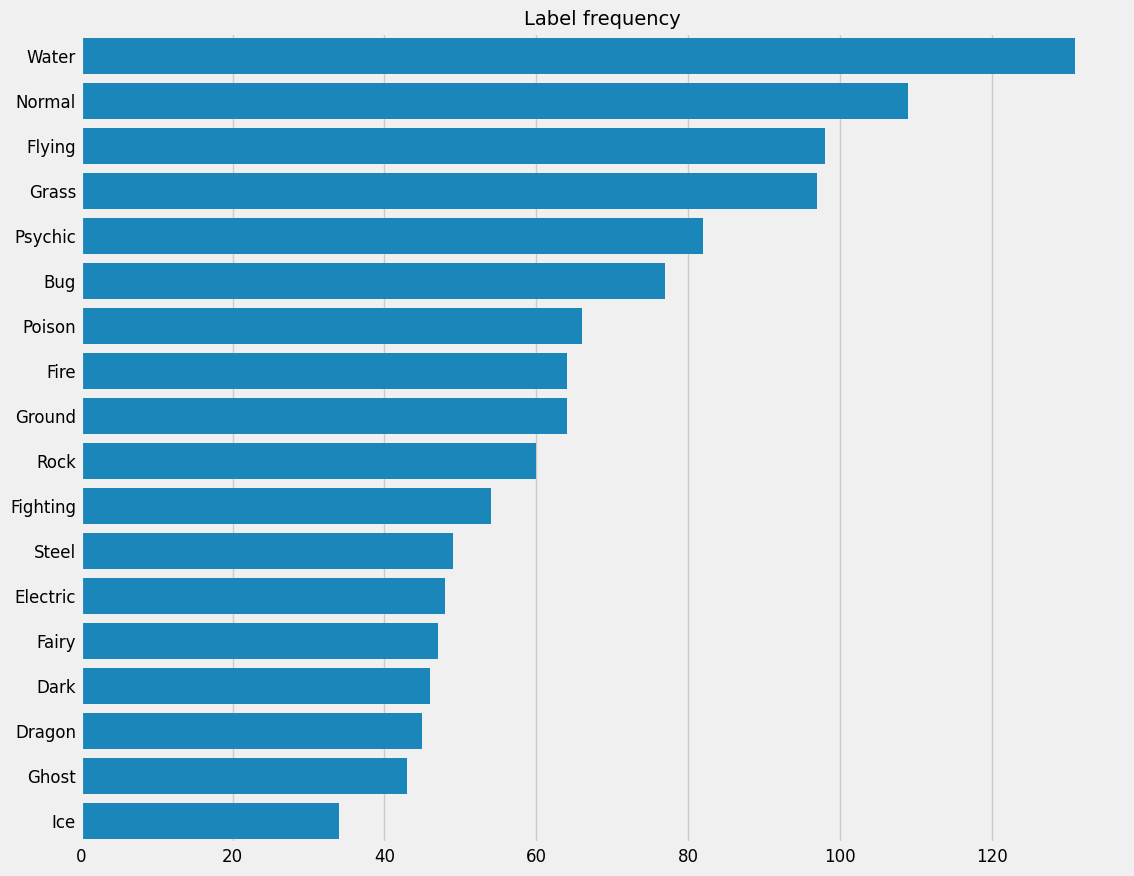

In [6]:
# Get label frequencies in descending order
label_freq = df['Type'].apply(lambda s: str(s).split(' ')).explode().binary_cross_entropy().sort_values(ascending=False)

# Bar plot
mpl.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# TODO more data exploration 

## Data Preparation 

Our goal is to produce a `tf.data.Dataset` that serves (image, label) batches during training.  

image:  a normalized, rescaled RBG tensor.  Shape is (DIM_H, DIM_W, 3)   
label:  a multi-hot encoded vector of types.  A pokemon can have 1 or 2 types.  

### Fix Type column so that its a list of Types 

In [8]:
# First, make the Type column a list 
df['Type'] = df['Type'].apply(lambda s: [l for l in str(s).split(' ')])
df.head()

,Name,Type1,Type2,Type
0,bulbasaur,Grass,Poison,"[Grass, Poison]"
1,ivysaur,Grass,Poison,"[Grass, Poison]"
2,venusaur,Grass,Poison,"[Grass, Poison]"
3,charmander,Fire,NaN,[Fire]
4,charmeleon,Fire,NaN,[Fire]


### Train/Validation/Test split 


In [9]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(df['Name'], df['Type'], test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1)

print("Training set size: \t", len(X_train))
print("Validation set size: \t", len(X_val))
print("Test set size: \t\t", len(X_test))


Training set size: 	 691
Validation set size: 	 77
Test set size: 		 41


### Add label for filepath 

Temporarily, we will let our X variables represent the path to an image file.  

In [10]:
import os 

X_train =  [os.path.join("./data/", str(f) + '.png') for f in X_train] 
X_val =  [os.path.join("./data/", str(f) + '.png') for f in X_val] 
X_test =  [os.path.join("./data/", str(f) + '.png') for f in X_test] 
       
            
X_train[:3]

['./data/plusle.png', './data/remoraid.png', './data/lilligant.png']

### Turn labels into lists 
Convert y variables from Series to list form.  Easier to process and index when building the pipeline.  

In [11]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

y_train[:3]

[['Electric'], ['Water'], ['Grass']]

### View data 
Display some images to verify the state of our X and y so far.  

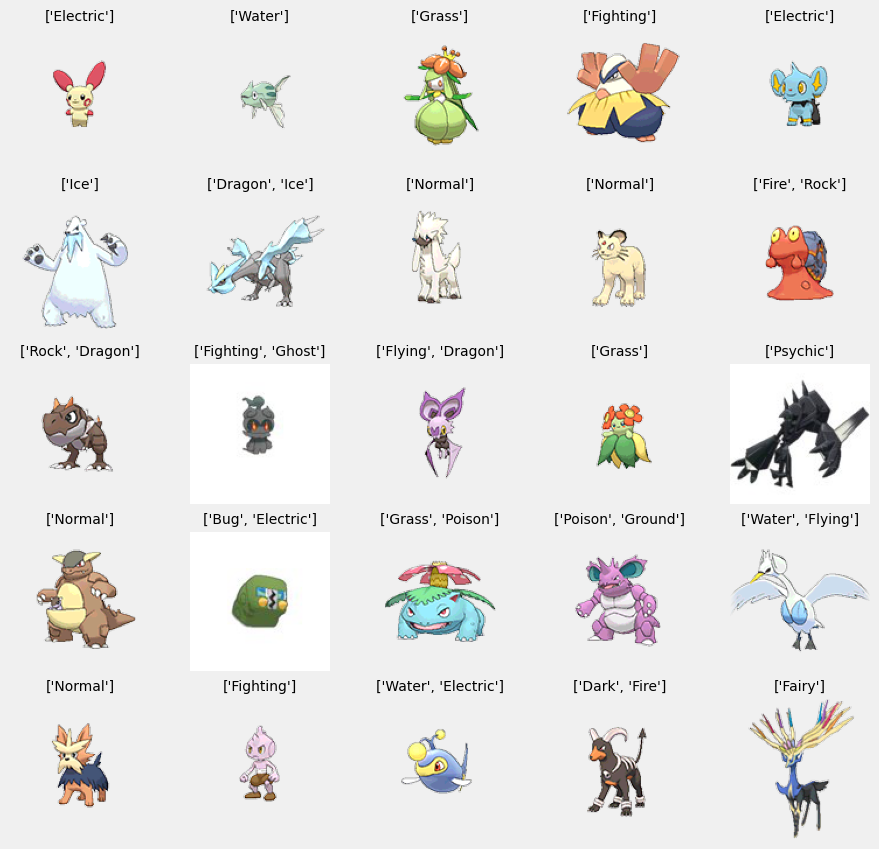

In [12]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):
    
    img_path = X_train[i]
    label = y_train[i]   
    
    ax.set_title(label, size=10)
    ax.imshow(Image.open(str(img_path)))
    ax.axis(False)
    

### Label encoding 
Using sklearn's `MultiLabelBinarizer` to multi-hot encode the labels.  

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

type_encoding = {}

mlb = MultiLabelBinarizer()
mlb.fit(y_train)

print("Labels: ")
# Loop over all labels and show 
N_LABELS = len(mlb.classes_)
for i, label in enumerate(mlb.classes_): 
    print("{}. {}".format(i, label))
    type_encoding[i] = label 
    

Labels: 
0. Bug
1. Dark
2. Dragon
3. Electric
4. Fairy
5. Fighting
6. Fire
7. Flying
8. Ghost
9. Grass
10. Ground
11. Ice
12. Normal
13. Poison
14. Psychic
15. Rock
16. Steel
17. Water


In [14]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)


# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])


./data/plusle.png [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
./data/remoraid.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
./data/lilligant.png [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Verify data shapes 

In [15]:
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((691, 18), (77, 18), (41, 18))

In [16]:
len(X_train), len(X_val), len(X_test)

(691, 77, 41)

### Save X to file

In [17]:
np.savetxt('data/munged/X_train.csv', np.array(X_train), fmt='%s')
np.savetxt('data/munged/X_val.csv', np.array(X_val), fmt='%s')
np.savetxt('data/munged/X_test.csv', np.array(X_test), fmt='%s')

### Save y to file 

In [18]:
np.savetxt('data/munged/y_train.csv', y_train_bin, delimiter=',') 
np.savetxt('data/munged/y_val.csv', y_val_bin, delimiter=',') 
np.savetxt('data/munged/y_test.csv', y_test_bin, delimiter=',') 

In [19]:
import json

In [20]:
json_tmp = json.dumps(type_encoding)

f = open("data/munged/labels.json","w")   
f.write(json_tmp)   
f.close()  